In [1]:
# IPython magic to import matplotlib and plot inline
%matplotlib inline

# FEniCS How-Tos


In [2]:
import fenics as fe
import mshr 

## Advanced Meshing

Meshes for more complex geometries can be generated via [fenics-mshr](https://fenics.readthedocs.io/projects/mshr/en/latest/) / [CGAL](https://www.cgal.org). See [this](http://anders.logg.org/2016/06/02/mesh-generation-in-fenics/) for an advanced example.

In [3]:
# combine geometric shapes
domain = mshr.Rectangle(fe.Point(0.0,0.0),fe.Point(10,5)) \
         - mshr.Circle(fe.Point(2,1.5),r=1,segments=5)    \
         - mshr.Circle(fe.Point(5,1.5),r=0.5,segments=0)    \
         + mshr.Circle(fe.Point(0.0,0.0),r=1,segments=100)    
# define subdomains that are meshed spearately
domain.set_subdomain(1, mshr.Rectangle(fe.Point(8,0.5),fe.Point(9,4.5)))
domain.set_subdomain(2, mshr.Circle(fe.Point(7.,1.),r=0.5, segments=100))
mesh = mshr.generate_mesh(domain, 30)

In [4]:
mesh

Subdomains are accessible as part of the mesh:

In [5]:
# markers for dim=2 (cells in 2D == faces)
mesh.domains().markers(2).values()

dict_values([0, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

We can use this information to create a `MeshFunction`:

In [6]:
domains = fe.MeshFunction('size_t', mesh, mesh.geometric_dimension()) 
domains.set_values(list(mesh.domains().markers(2).values()))

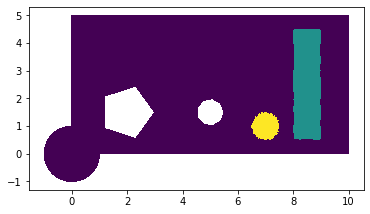

In [7]:
fe.plot(domains)

## Subdomains (cells, facets, edges)

The [`MeshFunction`](https://fenicsproject.org/docs/dolfin/1.6.0/python/programmers-reference/cpp/mesh/MeshFunction.html) class allows marking subdomains (1D, 2D, 3D) on a mesh.
Good examples are provided [here](https://fenicsproject.org/docs/dolfin/1.4.0/python/demo/documented/subdomains/python/documentation.html) and [here](https://fenicsproject.org/pub/tutorial/sphinx1/._ftut1005.html).

A MeshFunction is specific to a mesh and refers to mesh entitities of a specific geometric dimension:
- dim=3 -> cells
- dim=2 -> facets
- dim=1 -> edges

### 2D Mesh
For 2D meshes, cells and facets are equivalent.

In [8]:
mesh_2d = fe.RectangleMesh(fe.Point(0,0),fe.Point(5,5), nx=5, ny=5)

domains_cells_2d = fe.MeshFunction('size_t', mesh_2d, 2) 

A MeshFunction associates an integer number to each entitiy (of the corresponding dimension) of the mesh.

In [9]:
print("Mesh has %i cells."%len(mesh_2d.cells()))
print("%i MeshFunction values: "% len(domains_cells_2d.array()), domains_cells_2d.array())

Mesh has 50 cells.
50 MeshFunction values:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


Subdomains are created by setting MeshFunction values:

In [10]:
domains_cells_2d.set_all(0)
domains_cells_2d.set_value(6,1) # set entity 6 to value 1
domains_cells_2d.set_value(7,1)
domains_cells_2d.set_value(8,2) # set entity 8 to value 2
domains_cells_2d.set_value(9,2)
print("%i MeshFunction values: "% len(domains_cells_2d.array()), domains_cells_2d.array())

50 MeshFunction values:  [0 0 0 0 0 0 1 1 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


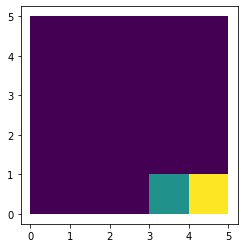

In [11]:
fe.plot(domains_cells_2d)

FEniCS provides the [`SubDomain`](https://fenicsproject.org/docs/dolfin/1.6.0/python/programmers-reference/cpp/mesh/SubDomain.html) class for for identifying mesh entitites and setting MeshFunction values.

50 MeshFunction values:  [0 0 0 0 0 0 1 1 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 3 3 3 3 0 0]


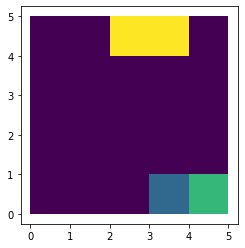

In [12]:
# create class that inherits from fe.SubDomain
class SubdomainRegion(fe.SubDomain):
    def inside(self, x, on_boundary):
        return x[0]>=2 and x[0]<=4 and x[1]>=4

region = SubdomainRegion()
region.mark(domains_cells_2d, 3)
fe.plot(domains_cells_2d)
print("%i MeshFunction values: "% len(domains_cells_2d.array()), domains_cells_2d.array())

Similarly for Edges, or geometrical dimension -1 more generally:

In [13]:
domains_edges_2d  = fe.MeshFunction('size_t', mesh_2d, 1) 
print("%i MeshFunction values: "% len(domains_edges_2d.array()), domains_edges_2d.array())

# using the internal on_boundary function
class LeftSide(fe.SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and fe.near(x[0], 0, tol)
    
left = LeftSide()
left.mark(domains_edges_2d, 3)
print("%i MeshFunction values: "% len(domains_edges_2d.array()), domains_edges_2d.array())


85 MeshFunction values:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
85 MeshFunction values:  [0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]


### 3D Mesh

The same concepts can be used in 3D.

In [14]:
mesh_3d = fe.BoxMesh(fe.Point(0,0,0), fe.Point(5,1,1), 10, 5, 5)
mesh_3d

In [15]:
domains_cells_3d   = fe.MeshFunction('size_t', mesh_3d, mesh_3d.geometric_dimension()) 
domains_facets_3d  = fe.MeshFunction('size_t', mesh_3d, mesh_3d.geometric_dimension()-1) 
domains_cells_3d.set_all(0)
domains_facets_3d.set_all(0)

In [16]:
class SubdomainRegion(fe.SubDomain):
    def inside(self, x, on_boundary):
        return x[0]>=2 and x[0]<=4

region = SubdomainRegion()
region.mark(domains_cells_3d, 1)

subdomain_file = fe.File("subdomains.pvd")
subdomain_file << domains_cells_3d

In [17]:
# using LeftSide class from 2D example
left = LeftSide()
left.mark(domains_facets_3d, 1)

# more compact way to specify subdomains, no need to define new class
right = fe.CompiledSubDomain('on_boundary && near(x[0], 5, tol)', tol=1E-14)
right.mark(domains_facets_3d, 2)

boundaries_file = fe.File("boundaries.pvd")
boundaries_file << domains_facets_3d

### Subdomains for different materials

See [this](https://fenicsproject.org/pub/tutorial/sphinx1/._ftut1005.html) example, around eq. 68.

## Integration over subdomains
Instances of class `MeshFunction` can be used to define integration regions. 
Integration volumes/regions are identified by a `Measure`. 
The default measures are `dx` for volume and `ds` for surface integrals over the entire domain/mesh.

Providing a MeshFunction with subdomain information to those measures allows us to integrate over specific subdomains.


In [18]:
ds = fe.Measure('ds', domain=mesh_3d, subdomain_data=domains_facets_3d)
dx = fe.Measure('dx', domain=mesh_3d, subdomain_data=domains_cells_3d)

Integration over the left side of the beam defined above would be expressed by `ds(1)` because we marked up this surface with a mesh function value of 1.

Compare integration over the full domain surface(`fe.ds`) to integration over the left surface only:

In [19]:
# constant 3D vector
f = fe.Constant((-1,0,0))
# surface normals of the beam
n = fe.FacetNormal(mesh_3d)

print("integral over entire surface:      ", fe.assemble(fe.inner(f,n)*ds) )
print("integral over left surface only:   ", fe.assemble(fe.inner(f,n)*ds(1)) )
print("integral over right surface only:   ", fe.assemble(fe.inner(f,n)*ds(2)) )

integral over entire surface:       0.0
integral over left surface only:    1.0000000000000007
integral over right surface only:    -1.0000000000000007


## Boundary Conditions

Instances of class `MeshFunction` can be used to define boundary conditions over subdomains.  

### Dirichlet BC

e.g. zero displacement at left side of beam:

In [20]:
V = fe.VectorFunctionSpace(mesh_3d, "Lagrange", 1)
u_0 = fe.Constant((0,0,0))

bc = fe.DirichletBC(V, u_0, domains_facets_3d, 1)

### Von Neuman

Typically via integration over subdomain as shown above.

## File IO

Different mechanisms exist for saving and loading meshes, subdomains and functions:

In [24]:
# define mesh and test function to be visualized
mesh = fe.UnitCubeMesh(10,10,10)
V = fe.FunctionSpace(mesh, "Lagrange", 1)
f_expr = fe.Expression("exp( - pow(x[0]-x0, 2) / pow(sigma_x, 2) - pow(x[1]-y0, 2) / pow(sigma_y, 2) - pow(x[2]-z0, 2) / pow(sigma_z, 2))", 
                                    x0=0, y0=0, z0=0, sigma_x=1, sigma_y=1, sigma_z=1, degree = 1)
fun = fe.project(f_expr, V)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


### VTK Unstructured grid PVD/VTU

*pvd* is a wrapper that can compose multiple *vtu* (vtk unstructured grid) files. 
The following command creates a *pdv* with one linked *vtu* file.
Both can be opened and visualized in [ParaView](https://www.paraview.org/).

In [27]:
vtkfile = fe.File('output/function.pvd')
vtkfile << (fun)

Multiple functions can be combined by adding a (numeric) label.
Paraview interprets this information as time steps.

In [30]:
vtkfile = fe.File('output/function_steps.pvd')
vtkfile << (fun, 1)
vtkfile << (fun, 2)
vtkfile << (fun, 3)

### XDMF

[XDMF](https://fenicsproject.org/docs/dolfin/2017.2.0/python/programmers-reference/cpp/io/XDMFFile.html):
Note that the file has to be closed after writing.
Choose 'Xdmf3ReaderT' when prompted by ParaView.

In [41]:
xdmffile = fe.XDMFFile(mesh.mpi_comm(), 'output/function.xdmf')
xdmffile.write_checkpoint(fun, 'function1', 1., encoding=fe.XDMFFile.Encoding.HDF5, append=False)
xdmffile.write_checkpoint(fun, 'function1', 2., encoding=fe.XDMFFile.Encoding.HDF5, append=True)
xdmffile.write_checkpoint(fun, 'function1', 3., encoding=fe.XDMFFile.Encoding.HDF5, append=True)
xdmffile.close()

In principle, this allows writing multiple functions to the same mesh file by specifying different function names.
However, visualization of such composed datasets in ParaView appears not be working.

Besides *Functions*, instances of *Mesh* and *MeshFunction* can also be saved:

In [55]:
# save MESH (from above)
xdmffile = fe.XDMFFile('output/Mesh.xdmf')
xdmffile.write(mesh_3d)
xdmffile.close()

# save MESHFUNCTION (Subdomains for Boundary Conditions)
xdmffile = fe.XDMFFile('output/Subdomains.xdmf')
xdmffile.write(domains_cells_3d)
xdmffile.close()

# save MESHFUNCTION (Subdomains for Boundary Conditions)
xdmffile = fe.XDMFFile('output/Boundaries.xdmf')
xdmffile.write(domains_facets_3d)
xdmffile.close()


And be reloaded:

In [53]:
mesh_reloaded = fe.Mesh()
xdmffile_mesh = fe.XDMFFile('output/Mesh.xdmf')
xdmffile_mesh.read(mesh_reloaded)

In [60]:
subdomains_reloaded = fe.MeshFunction('size_t', mesh_reloaded, mesh_reloaded.geometric_dimension())
xdmffile_subdomains = fe.XDMFFile('output/Subdomains.xdmf')
xdmffile_subdomains.read(subdomains_reloaded)
subdomains_reloaded

In [61]:
boundaries_reloaded = fe.MeshFunction('size_t', mesh_reloaded, mesh_reloaded.geometric_dimension()-1)
xdmffile_boundaries = fe.XDMFFile('output/Subdomains.xdmf')
xdmffile_boundaries.read(boundaries_reloaded)
boundaries_reloaded